In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_basepath="../../data/content/playground/auto/nostem",
                         basepath_suffix="_content.csv",
                         content_categories=product_list,
                         vector_length=500)

# initialize the vocab of documents and minimize the distances of embeddings in training phase
d2v_wrapper.init_model_vocab()
d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 10)

# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-04-03 13:14:28,055 : INFO : collecting all words and their counts
2017-04-03 13:14:28,056 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-03 13:14:28,256 : INFO : PROGRESS: at example #10000, processed 1393592 words (6963052/s), 63275 word types, 10000 tags
2017-04-03 13:14:28,431 : INFO : PROGRESS: at example #20000, processed 2550277 words (6658790/s), 95498 word types, 20000 tags
2017-04-03 13:14:28,646 : INFO : PROGRESS: at example #30000, processed 4063349 words (7032898/s), 124345 word types, 30000 tags
2017-04-03 13:14:28,821 : INFO : PROGRESS: at example #40000, processed 5280834 words (7017935/s), 147174 word types, 40000 tags
2017-04-03 13:14:28,993 : INFO : PROGRESS: at example #50000, processed 6427786 words (6667782/s), 175998 word types, 50000 tags
2017-04-03 13:14:29,119 : INFO : PROGRESS: at example #60000, processed 7236898 words (6475069/s), 205437 word types, 60000 tags
2017-04-03 13:14:29,249 : INFO : PROGRESS: at example

In [4]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [5]:
# encoding/decoding target categories
mapping = []


def encode_categories(target_series):
    global mapping
    if not len(mapping):
        for cat in target_series.unique():
            mapping.append(cat)

    return target_series.apply(lambda cat_str: mapping.index(cat_str))


def decode_categories(target_series):
    global mapping
    return target_series.apply(lambda cat_idx: mapping[cat_idx])

In [6]:
# transforms the given content to Tensorflow format
def dataset_from_dataframe(data_df, target_series):
    dataset = tf.contrib.learn.datasets.base.Dataset(data=data_df.values, target=encode_categories(target_series))
    return dataset

In [7]:
# classifier training and eval:

accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
correct_logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    train_vectors = doc_vectors.iloc[train_doc_indices]

    y_true = doc_labels.iloc[train_doc_indices]
    
    # 
    tf_dataset = dataset_from_dataframe(train_vectors, y_true)
    
    # columns are initialized as Tensors for TF
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=doc_vectors.shape[1])]
    
    # init model:
    # model consists of two layers as described in [2]
    # 1. dense, fully-connected layer with relu act. function
    # 2. softmax output layer for classification and further relevance scoring
    two_layer_nn_classifier = SKCompat(tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                                                  hidden_units=[doc_vectors.shape[1] / 2],
                                                                  activation_fn=tf.nn.relu,
                                                                  dropout=0.05,
                                                                  n_classes=len(d2v_wrapper.content_categories),
                                                                  optimizer="Adam"))
    # model training
    two_layer_nn_classifier.fit(x=tf_dataset.data,
                                y=tf_dataset.target,
                                steps=500 if TEST_MODE else 4000)

    # testing
    # can be used to infer the relative relevance (or score) of the document for categories    
    logits = two_layer_nn_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    y_actual = decode_categories(pd.Series(logits["classes"])).values
    y_expected = doc_labels.iloc[test_doc_indices].values

    # evaluation:
    # logits
    actual_prob = logits["probabilities"][np.arange(len(logits["probabilities"])),(logits["classes"])]
    expected_prob = logits["probabilities"][np.arange(len(logits["probabilities"])),(encode_categories(pd.Series(y_expected)))]
    new_logits = pd.DataFrame()
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    correct_logits = correct_logits.append(new_logits)
    
    # accuracy
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.warn("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.warn("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))
    
    # misclassified docs collection
    wrong_docs_ids = wrong_docs_ids.append(pd.Series(test_doc_indices[y_actual != y_expected]))

2017-04-03 13:52:01,696 : WARNING : Using temporary folder as model directory: /tmp/tmpMHMEO_


INFO:tensorflow:Using default config.


2017-04-03 13:52:01,697 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff46e729dd0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:52:01,698 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff46e729dd0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:52:01,699 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 13:52:01,955 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 13:52:02,234 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpMHMEO_/model.ckpt.


2017-04-03 13:52:04,234 : INFO : Saving checkpoints for 1 into /tmp/tmpMHMEO_/model.ckpt.


INFO:tensorflow:loss = 2.67744, step = 1


2017-04-03 13:52:04,768 : INFO : loss = 2.67744, step = 1


INFO:tensorflow:global_step/sec: 161.731


2017-04-03 13:52:05,385 : INFO : global_step/sec: 161.731


INFO:tensorflow:loss = 0.604716, step = 101


2017-04-03 13:52:05,387 : INFO : loss = 0.604716, step = 101


INFO:tensorflow:global_step/sec: 161.935


2017-04-03 13:52:06,002 : INFO : global_step/sec: 161.935


INFO:tensorflow:loss = 0.759951, step = 201


2017-04-03 13:52:06,005 : INFO : loss = 0.759951, step = 201


INFO:tensorflow:global_step/sec: 161.658


2017-04-03 13:52:06,621 : INFO : global_step/sec: 161.658


INFO:tensorflow:loss = 0.599138, step = 301


2017-04-03 13:52:06,623 : INFO : loss = 0.599138, step = 301


INFO:tensorflow:global_step/sec: 162.438


2017-04-03 13:52:07,236 : INFO : global_step/sec: 162.438


INFO:tensorflow:loss = 0.482096, step = 401


2017-04-03 13:52:07,239 : INFO : loss = 0.482096, step = 401


INFO:tensorflow:global_step/sec: 161.625


2017-04-03 13:52:07,855 : INFO : global_step/sec: 161.625


INFO:tensorflow:loss = 0.435548, step = 501


2017-04-03 13:52:07,858 : INFO : loss = 0.435548, step = 501


INFO:tensorflow:global_step/sec: 159.169


2017-04-03 13:52:08,483 : INFO : global_step/sec: 159.169


INFO:tensorflow:loss = 0.565559, step = 601


2017-04-03 13:52:08,486 : INFO : loss = 0.565559, step = 601


INFO:tensorflow:global_step/sec: 158.486


2017-04-03 13:52:09,114 : INFO : global_step/sec: 158.486


INFO:tensorflow:loss = 0.822101, step = 701


2017-04-03 13:52:09,117 : INFO : loss = 0.822101, step = 701


INFO:tensorflow:global_step/sec: 143.293


2017-04-03 13:52:09,812 : INFO : global_step/sec: 143.293


INFO:tensorflow:loss = 0.515, step = 801


2017-04-03 13:52:09,816 : INFO : loss = 0.515, step = 801


INFO:tensorflow:global_step/sec: 140.47


2017-04-03 13:52:10,524 : INFO : global_step/sec: 140.47


INFO:tensorflow:loss = 0.826517, step = 901


2017-04-03 13:52:10,527 : INFO : loss = 0.826517, step = 901


INFO:tensorflow:global_step/sec: 146.934


2017-04-03 13:52:11,205 : INFO : global_step/sec: 146.934


INFO:tensorflow:loss = 0.84773, step = 1001


2017-04-03 13:52:11,207 : INFO : loss = 0.84773, step = 1001


INFO:tensorflow:global_step/sec: 147.601


2017-04-03 13:52:11,882 : INFO : global_step/sec: 147.601


INFO:tensorflow:loss = 0.616143, step = 1101


2017-04-03 13:52:11,885 : INFO : loss = 0.616143, step = 1101


INFO:tensorflow:global_step/sec: 146.706


2017-04-03 13:52:12,564 : INFO : global_step/sec: 146.706


INFO:tensorflow:loss = 0.770852, step = 1201


2017-04-03 13:52:12,566 : INFO : loss = 0.770852, step = 1201


INFO:tensorflow:global_step/sec: 146.442


2017-04-03 13:52:13,247 : INFO : global_step/sec: 146.442


INFO:tensorflow:loss = 0.86583, step = 1301


2017-04-03 13:52:13,249 : INFO : loss = 0.86583, step = 1301


INFO:tensorflow:global_step/sec: 145.362


2017-04-03 13:52:13,935 : INFO : global_step/sec: 145.362


INFO:tensorflow:loss = 0.584669, step = 1401


2017-04-03 13:52:13,938 : INFO : loss = 0.584669, step = 1401


INFO:tensorflow:global_step/sec: 144.181


2017-04-03 13:52:14,628 : INFO : global_step/sec: 144.181


INFO:tensorflow:loss = 0.495196, step = 1501


2017-04-03 13:52:14,631 : INFO : loss = 0.495196, step = 1501


INFO:tensorflow:global_step/sec: 146.763


2017-04-03 13:52:15,310 : INFO : global_step/sec: 146.763


INFO:tensorflow:loss = 0.612352, step = 1601


2017-04-03 13:52:15,312 : INFO : loss = 0.612352, step = 1601


INFO:tensorflow:global_step/sec: 147.342


2017-04-03 13:52:15,988 : INFO : global_step/sec: 147.342


INFO:tensorflow:loss = 0.846919, step = 1701


2017-04-03 13:52:15,991 : INFO : loss = 0.846919, step = 1701


INFO:tensorflow:global_step/sec: 146.808


2017-04-03 13:52:16,669 : INFO : global_step/sec: 146.808


INFO:tensorflow:loss = 0.847404, step = 1801


2017-04-03 13:52:16,672 : INFO : loss = 0.847404, step = 1801


INFO:tensorflow:global_step/sec: 147.661


2017-04-03 13:52:17,347 : INFO : global_step/sec: 147.661


INFO:tensorflow:loss = 0.544983, step = 1901


2017-04-03 13:52:17,350 : INFO : loss = 0.544983, step = 1901


INFO:tensorflow:global_step/sec: 146.197


2017-04-03 13:52:18,031 : INFO : global_step/sec: 146.197


INFO:tensorflow:loss = 0.603514, step = 2001


2017-04-03 13:52:18,033 : INFO : loss = 0.603514, step = 2001


INFO:tensorflow:global_step/sec: 147.486


2017-04-03 13:52:18,709 : INFO : global_step/sec: 147.486


INFO:tensorflow:loss = 0.709417, step = 2101


2017-04-03 13:52:18,711 : INFO : loss = 0.709417, step = 2101


INFO:tensorflow:global_step/sec: 149.462


2017-04-03 13:52:19,378 : INFO : global_step/sec: 149.462


INFO:tensorflow:loss = 0.698951, step = 2201


2017-04-03 13:52:19,381 : INFO : loss = 0.698951, step = 2201


INFO:tensorflow:global_step/sec: 147.346


2017-04-03 13:52:20,056 : INFO : global_step/sec: 147.346


INFO:tensorflow:loss = 0.369135, step = 2301


2017-04-03 13:52:20,059 : INFO : loss = 0.369135, step = 2301


INFO:tensorflow:global_step/sec: 142.969


2017-04-03 13:52:20,756 : INFO : global_step/sec: 142.969


INFO:tensorflow:loss = 0.473938, step = 2401


2017-04-03 13:52:20,759 : INFO : loss = 0.473938, step = 2401


INFO:tensorflow:global_step/sec: 117.606


2017-04-03 13:52:21,606 : INFO : global_step/sec: 117.606


INFO:tensorflow:loss = 0.595126, step = 2501


2017-04-03 13:52:21,610 : INFO : loss = 0.595126, step = 2501


INFO:tensorflow:global_step/sec: 120.343


2017-04-03 13:52:22,437 : INFO : global_step/sec: 120.343


INFO:tensorflow:loss = 0.670837, step = 2601


2017-04-03 13:52:22,440 : INFO : loss = 0.670837, step = 2601


INFO:tensorflow:global_step/sec: 114.156


2017-04-03 13:52:23,313 : INFO : global_step/sec: 114.156


INFO:tensorflow:loss = 0.692781, step = 2701


2017-04-03 13:52:23,316 : INFO : loss = 0.692781, step = 2701


INFO:tensorflow:global_step/sec: 131.486


2017-04-03 13:52:24,074 : INFO : global_step/sec: 131.486


INFO:tensorflow:loss = 2.13515, step = 2801


2017-04-03 13:52:24,077 : INFO : loss = 2.13515, step = 2801


INFO:tensorflow:global_step/sec: 146.945


2017-04-03 13:52:24,754 : INFO : global_step/sec: 146.945


INFO:tensorflow:loss = 0.522621, step = 2901


2017-04-03 13:52:24,757 : INFO : loss = 0.522621, step = 2901


INFO:tensorflow:global_step/sec: 148.632


2017-04-03 13:52:25,427 : INFO : global_step/sec: 148.632


INFO:tensorflow:loss = 0.75336, step = 3001


2017-04-03 13:52:25,430 : INFO : loss = 0.75336, step = 3001


INFO:tensorflow:global_step/sec: 148.06


2017-04-03 13:52:26,102 : INFO : global_step/sec: 148.06


INFO:tensorflow:loss = 0.752938, step = 3101


2017-04-03 13:52:26,105 : INFO : loss = 0.752938, step = 3101


INFO:tensorflow:global_step/sec: 147.209


2017-04-03 13:52:26,782 : INFO : global_step/sec: 147.209


INFO:tensorflow:loss = 0.57217, step = 3201


2017-04-03 13:52:26,784 : INFO : loss = 0.57217, step = 3201


INFO:tensorflow:global_step/sec: 148.544


2017-04-03 13:52:27,455 : INFO : global_step/sec: 148.544


INFO:tensorflow:loss = 0.527986, step = 3301


2017-04-03 13:52:27,457 : INFO : loss = 0.527986, step = 3301


INFO:tensorflow:global_step/sec: 146.902


2017-04-03 13:52:28,136 : INFO : global_step/sec: 146.902


INFO:tensorflow:loss = 0.545208, step = 3401


2017-04-03 13:52:28,138 : INFO : loss = 0.545208, step = 3401


INFO:tensorflow:global_step/sec: 149.642


2017-04-03 13:52:28,804 : INFO : global_step/sec: 149.642


INFO:tensorflow:loss = 0.709143, step = 3501


2017-04-03 13:52:28,807 : INFO : loss = 0.709143, step = 3501


INFO:tensorflow:global_step/sec: 146.822


2017-04-03 13:52:29,485 : INFO : global_step/sec: 146.822


INFO:tensorflow:loss = 0.491333, step = 3601


2017-04-03 13:52:29,488 : INFO : loss = 0.491333, step = 3601


INFO:tensorflow:global_step/sec: 147.349


2017-04-03 13:52:30,164 : INFO : global_step/sec: 147.349


INFO:tensorflow:loss = 0.529415, step = 3701


2017-04-03 13:52:30,167 : INFO : loss = 0.529415, step = 3701


INFO:tensorflow:global_step/sec: 147.632


2017-04-03 13:52:30,841 : INFO : global_step/sec: 147.632


INFO:tensorflow:loss = 0.436837, step = 3801


2017-04-03 13:52:30,844 : INFO : loss = 0.436837, step = 3801


INFO:tensorflow:global_step/sec: 147.358


2017-04-03 13:52:31,520 : INFO : global_step/sec: 147.358


INFO:tensorflow:loss = 0.52981, step = 3901


2017-04-03 13:52:31,523 : INFO : loss = 0.52981, step = 3901


INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpMHMEO_/model.ckpt.


2017-04-03 13:52:32,191 : INFO : Saving checkpoints for 4000 into /tmp/tmpMHMEO_/model.ckpt.


INFO:tensorflow:Loss for final step: 0.659695.


2017-04-03 13:52:32,478 : INFO : Loss for final step: 0.659695.


2017-04-03 13:52:32,591 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 13:52:32,995 : WARNING : Run accuracy: 0.812949640288
2017-04-03 13:52:33,008 : WARNING : Cat accuracies:
[0.0, 0.9473604826546003, 0.006329113924050633, 0.4166666666666667, 0.7702702702702703, 0.3202614379084967, 0.4948453608247423, 0.7004175365344467, 0.0, 0.0, 0.885, 0.0, 0.0, 0.7991329479768786]


2017-04-03 13:52:33,255 : WARNING : Using temporary folder as model directory: /tmp/tmpvTZmbA


INFO:tensorflow:Using default config.


2017-04-03 13:52:33,257 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff4263306d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:52:33,257 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff4263306d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:52:33,258 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 13:52:33,328 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 13:52:33,597 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpvTZmbA/model.ckpt.


2017-04-03 13:52:35,413 : INFO : Saving checkpoints for 1 into /tmp/tmpvTZmbA/model.ckpt.


INFO:tensorflow:loss = 2.7113, step = 1


2017-04-03 13:52:35,923 : INFO : loss = 2.7113, step = 1


INFO:tensorflow:global_step/sec: 163.218


2017-04-03 13:52:36,534 : INFO : global_step/sec: 163.218


INFO:tensorflow:loss = 0.663445, step = 101


2017-04-03 13:52:36,537 : INFO : loss = 0.663445, step = 101


INFO:tensorflow:global_step/sec: 163.9


2017-04-03 13:52:37,145 : INFO : global_step/sec: 163.9


INFO:tensorflow:loss = 0.626801, step = 201


2017-04-03 13:52:37,147 : INFO : loss = 0.626801, step = 201


INFO:tensorflow:global_step/sec: 165.221


2017-04-03 13:52:37,750 : INFO : global_step/sec: 165.221


INFO:tensorflow:loss = 0.664924, step = 301


2017-04-03 13:52:37,752 : INFO : loss = 0.664924, step = 301


INFO:tensorflow:global_step/sec: 164.523


2017-04-03 13:52:38,358 : INFO : global_step/sec: 164.523


INFO:tensorflow:loss = 0.539503, step = 401


2017-04-03 13:52:38,361 : INFO : loss = 0.539503, step = 401


INFO:tensorflow:global_step/sec: 164.356


2017-04-03 13:52:38,966 : INFO : global_step/sec: 164.356


INFO:tensorflow:loss = 0.535717, step = 501


2017-04-03 13:52:38,969 : INFO : loss = 0.535717, step = 501


INFO:tensorflow:global_step/sec: 163.943


2017-04-03 13:52:39,576 : INFO : global_step/sec: 163.943


INFO:tensorflow:loss = 0.703298, step = 601


2017-04-03 13:52:39,579 : INFO : loss = 0.703298, step = 601


INFO:tensorflow:global_step/sec: 163.174


2017-04-03 13:52:40,189 : INFO : global_step/sec: 163.174


INFO:tensorflow:loss = 0.601647, step = 701


2017-04-03 13:52:40,192 : INFO : loss = 0.601647, step = 701


INFO:tensorflow:global_step/sec: 144.304


2017-04-03 13:52:40,882 : INFO : global_step/sec: 144.304


INFO:tensorflow:loss = 0.653302, step = 801


2017-04-03 13:52:40,885 : INFO : loss = 0.653302, step = 801


INFO:tensorflow:global_step/sec: 143.819


2017-04-03 13:52:41,577 : INFO : global_step/sec: 143.819


INFO:tensorflow:loss = 0.784162, step = 901


2017-04-03 13:52:41,580 : INFO : loss = 0.784162, step = 901


INFO:tensorflow:global_step/sec: 147.531


2017-04-03 13:52:42,255 : INFO : global_step/sec: 147.531


INFO:tensorflow:loss = 0.646757, step = 1001


2017-04-03 13:52:42,258 : INFO : loss = 0.646757, step = 1001


INFO:tensorflow:global_step/sec: 148.252


2017-04-03 13:52:42,930 : INFO : global_step/sec: 148.252


INFO:tensorflow:loss = 0.656169, step = 1101


2017-04-03 13:52:42,932 : INFO : loss = 0.656169, step = 1101


INFO:tensorflow:global_step/sec: 148.364


2017-04-03 13:52:43,604 : INFO : global_step/sec: 148.364


INFO:tensorflow:loss = 0.733553, step = 1201


2017-04-03 13:52:43,606 : INFO : loss = 0.733553, step = 1201


INFO:tensorflow:global_step/sec: 147.677


2017-04-03 13:52:44,281 : INFO : global_step/sec: 147.677


INFO:tensorflow:loss = 0.779852, step = 1301


2017-04-03 13:52:44,283 : INFO : loss = 0.779852, step = 1301


INFO:tensorflow:global_step/sec: 148.591


2017-04-03 13:52:44,954 : INFO : global_step/sec: 148.591


INFO:tensorflow:loss = 0.484714, step = 1401


2017-04-03 13:52:44,956 : INFO : loss = 0.484714, step = 1401


INFO:tensorflow:global_step/sec: 147.753


2017-04-03 13:52:45,630 : INFO : global_step/sec: 147.753


INFO:tensorflow:loss = 0.455706, step = 1501


2017-04-03 13:52:45,633 : INFO : loss = 0.455706, step = 1501


INFO:tensorflow:global_step/sec: 147.279


2017-04-03 13:52:46,309 : INFO : global_step/sec: 147.279


INFO:tensorflow:loss = 0.614839, step = 1601


2017-04-03 13:52:46,312 : INFO : loss = 0.614839, step = 1601


INFO:tensorflow:global_step/sec: 148.178


2017-04-03 13:52:46,984 : INFO : global_step/sec: 148.178


INFO:tensorflow:loss = 0.682372, step = 1701


2017-04-03 13:52:46,987 : INFO : loss = 0.682372, step = 1701


INFO:tensorflow:global_step/sec: 147.915


2017-04-03 13:52:47,660 : INFO : global_step/sec: 147.915


INFO:tensorflow:loss = 0.780736, step = 1801


2017-04-03 13:52:47,663 : INFO : loss = 0.780736, step = 1801


INFO:tensorflow:global_step/sec: 149.082


2017-04-03 13:52:48,331 : INFO : global_step/sec: 149.082


INFO:tensorflow:loss = 0.536966, step = 1901


2017-04-03 13:52:48,334 : INFO : loss = 0.536966, step = 1901


INFO:tensorflow:global_step/sec: 148.789


2017-04-03 13:52:49,003 : INFO : global_step/sec: 148.789


INFO:tensorflow:loss = 0.567457, step = 2001


2017-04-03 13:52:49,006 : INFO : loss = 0.567457, step = 2001


INFO:tensorflow:global_step/sec: 147.946


2017-04-03 13:52:49,679 : INFO : global_step/sec: 147.946


INFO:tensorflow:loss = 0.537812, step = 2101


2017-04-03 13:52:49,682 : INFO : loss = 0.537812, step = 2101


INFO:tensorflow:global_step/sec: 147.819


2017-04-03 13:52:50,356 : INFO : global_step/sec: 147.819


INFO:tensorflow:loss = 0.763944, step = 2201


2017-04-03 13:52:50,358 : INFO : loss = 0.763944, step = 2201


INFO:tensorflow:global_step/sec: 147.554


2017-04-03 13:52:51,034 : INFO : global_step/sec: 147.554


INFO:tensorflow:loss = 0.312425, step = 2301


2017-04-03 13:52:51,036 : INFO : loss = 0.312425, step = 2301


INFO:tensorflow:global_step/sec: 147.007


2017-04-03 13:52:51,714 : INFO : global_step/sec: 147.007


INFO:tensorflow:loss = 0.659342, step = 2401


2017-04-03 13:52:51,717 : INFO : loss = 0.659342, step = 2401


INFO:tensorflow:global_step/sec: 146.731


2017-04-03 13:52:52,395 : INFO : global_step/sec: 146.731


INFO:tensorflow:loss = 0.497642, step = 2501


2017-04-03 13:52:52,398 : INFO : loss = 0.497642, step = 2501


INFO:tensorflow:global_step/sec: 146.364


2017-04-03 13:52:53,078 : INFO : global_step/sec: 146.364


INFO:tensorflow:loss = 0.802059, step = 2601


2017-04-03 13:52:53,081 : INFO : loss = 0.802059, step = 2601


INFO:tensorflow:global_step/sec: 147.474


2017-04-03 13:52:53,756 : INFO : global_step/sec: 147.474


INFO:tensorflow:loss = 0.543819, step = 2701


2017-04-03 13:52:53,759 : INFO : loss = 0.543819, step = 2701


INFO:tensorflow:global_step/sec: 146.681


2017-04-03 13:52:54,438 : INFO : global_step/sec: 146.681


INFO:tensorflow:loss = 0.708516, step = 2801


2017-04-03 13:52:54,441 : INFO : loss = 0.708516, step = 2801


INFO:tensorflow:global_step/sec: 146.32


2017-04-03 13:52:55,122 : INFO : global_step/sec: 146.32


INFO:tensorflow:loss = 0.577496, step = 2901


2017-04-03 13:52:55,125 : INFO : loss = 0.577496, step = 2901


INFO:tensorflow:global_step/sec: 142.723


2017-04-03 13:52:55,822 : INFO : global_step/sec: 142.723


INFO:tensorflow:loss = 0.693589, step = 3001


2017-04-03 13:52:55,825 : INFO : loss = 0.693589, step = 3001


INFO:tensorflow:global_step/sec: 147.016


2017-04-03 13:52:56,502 : INFO : global_step/sec: 147.016


INFO:tensorflow:loss = 0.798109, step = 3101


2017-04-03 13:52:56,506 : INFO : loss = 0.798109, step = 3101


INFO:tensorflow:global_step/sec: 148.49


2017-04-03 13:52:57,176 : INFO : global_step/sec: 148.49


INFO:tensorflow:loss = 0.568311, step = 3201


2017-04-03 13:52:57,179 : INFO : loss = 0.568311, step = 3201


INFO:tensorflow:global_step/sec: 147.392


2017-04-03 13:52:57,854 : INFO : global_step/sec: 147.392


INFO:tensorflow:loss = 0.525762, step = 3301


2017-04-03 13:52:57,857 : INFO : loss = 0.525762, step = 3301


INFO:tensorflow:global_step/sec: 148.276


2017-04-03 13:52:58,529 : INFO : global_step/sec: 148.276


INFO:tensorflow:loss = 0.65364, step = 3401


2017-04-03 13:52:58,531 : INFO : loss = 0.65364, step = 3401


INFO:tensorflow:global_step/sec: 147.664


2017-04-03 13:52:59,206 : INFO : global_step/sec: 147.664


INFO:tensorflow:loss = 0.669696, step = 3501


2017-04-03 13:52:59,209 : INFO : loss = 0.669696, step = 3501


INFO:tensorflow:global_step/sec: 145.768


2017-04-03 13:52:59,892 : INFO : global_step/sec: 145.768


INFO:tensorflow:loss = 0.611602, step = 3601


2017-04-03 13:52:59,895 : INFO : loss = 0.611602, step = 3601


INFO:tensorflow:global_step/sec: 145.702


2017-04-03 13:53:00,578 : INFO : global_step/sec: 145.702


INFO:tensorflow:loss = 0.62913, step = 3701


2017-04-03 13:53:00,581 : INFO : loss = 0.62913, step = 3701


INFO:tensorflow:global_step/sec: 148.711


2017-04-03 13:53:01,251 : INFO : global_step/sec: 148.711


INFO:tensorflow:loss = 0.804944, step = 3801


2017-04-03 13:53:01,254 : INFO : loss = 0.804944, step = 3801


INFO:tensorflow:global_step/sec: 147.526


2017-04-03 13:53:01,929 : INFO : global_step/sec: 147.526


INFO:tensorflow:loss = 0.701788, step = 3901


2017-04-03 13:53:01,931 : INFO : loss = 0.701788, step = 3901


INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpvTZmbA/model.ckpt.


2017-04-03 13:53:02,604 : INFO : Saving checkpoints for 4000 into /tmp/tmpvTZmbA/model.ckpt.


INFO:tensorflow:Loss for final step: 0.731205.


2017-04-03 13:53:02,890 : INFO : Loss for final step: 0.731205.


2017-04-03 13:53:03,003 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 13:53:03,348 : WARNING : Run accuracy: 0.811929144755
2017-04-03 13:53:03,358 : WARNING : Cat accuracies:
[0.18686868686868688, 0.9156862745098039, 0.3322784810126582, 0.37349397590361444, 0.8117760617760618, 0.4410480349344978, 0.2620689655172414, 0.6889352818371608, 0.0, 0.0, 0.8895, 0.0, 0.0, 0.7888647866955893]


2017-04-03 13:53:03,601 : WARNING : Using temporary folder as model directory: /tmp/tmpWMPGlp


INFO:tensorflow:Using default config.


2017-04-03 13:53:03,603 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff40fab58d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:53:03,604 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff40fab58d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:53:03,605 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 13:53:03,671 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 13:53:03,932 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpWMPGlp/model.ckpt.


2017-04-03 13:53:05,718 : INFO : Saving checkpoints for 1 into /tmp/tmpWMPGlp/model.ckpt.


INFO:tensorflow:loss = 2.71033, step = 1


2017-04-03 13:53:06,233 : INFO : loss = 2.71033, step = 1


INFO:tensorflow:global_step/sec: 159.746


2017-04-03 13:53:06,857 : INFO : global_step/sec: 159.746


INFO:tensorflow:loss = 0.485619, step = 101


2017-04-03 13:53:06,859 : INFO : loss = 0.485619, step = 101


INFO:tensorflow:global_step/sec: 162.282


2017-04-03 13:53:07,473 : INFO : global_step/sec: 162.282


INFO:tensorflow:loss = 0.663771, step = 201


2017-04-03 13:53:07,476 : INFO : loss = 0.663771, step = 201


INFO:tensorflow:global_step/sec: 160.644


2017-04-03 13:53:08,096 : INFO : global_step/sec: 160.644


INFO:tensorflow:loss = 0.854018, step = 301


2017-04-03 13:53:08,098 : INFO : loss = 0.854018, step = 301


INFO:tensorflow:global_step/sec: 158.931


2017-04-03 13:53:08,725 : INFO : global_step/sec: 158.931


INFO:tensorflow:loss = 0.538345, step = 401


2017-04-03 13:53:08,727 : INFO : loss = 0.538345, step = 401


INFO:tensorflow:global_step/sec: 160.119


2017-04-03 13:53:09,349 : INFO : global_step/sec: 160.119


INFO:tensorflow:loss = 0.587575, step = 501


2017-04-03 13:53:09,352 : INFO : loss = 0.587575, step = 501


INFO:tensorflow:global_step/sec: 160.827


2017-04-03 13:53:09,971 : INFO : global_step/sec: 160.827


INFO:tensorflow:loss = 0.648278, step = 601


2017-04-03 13:53:09,974 : INFO : loss = 0.648278, step = 601


INFO:tensorflow:global_step/sec: 159.616


2017-04-03 13:53:10,598 : INFO : global_step/sec: 159.616


INFO:tensorflow:loss = 0.483654, step = 701


2017-04-03 13:53:10,600 : INFO : loss = 0.483654, step = 701


INFO:tensorflow:global_step/sec: 141.864


2017-04-03 13:53:11,303 : INFO : global_step/sec: 141.864


INFO:tensorflow:loss = 0.762603, step = 801


2017-04-03 13:53:11,306 : INFO : loss = 0.762603, step = 801


INFO:tensorflow:global_step/sec: 138.889


2017-04-03 13:53:12,023 : INFO : global_step/sec: 138.889


INFO:tensorflow:loss = 0.730446, step = 901


2017-04-03 13:53:12,026 : INFO : loss = 0.730446, step = 901


INFO:tensorflow:global_step/sec: 143.177


2017-04-03 13:53:12,721 : INFO : global_step/sec: 143.177


INFO:tensorflow:loss = 0.703691, step = 1001


2017-04-03 13:53:12,724 : INFO : loss = 0.703691, step = 1001


INFO:tensorflow:global_step/sec: 147.022


2017-04-03 13:53:13,401 : INFO : global_step/sec: 147.022


INFO:tensorflow:loss = 0.587809, step = 1101


2017-04-03 13:53:13,404 : INFO : loss = 0.587809, step = 1101


INFO:tensorflow:global_step/sec: 146.031


2017-04-03 13:53:14,086 : INFO : global_step/sec: 146.031


INFO:tensorflow:loss = 0.616965, step = 1201


2017-04-03 13:53:14,088 : INFO : loss = 0.616965, step = 1201


INFO:tensorflow:global_step/sec: 145.277


2017-04-03 13:53:14,774 : INFO : global_step/sec: 145.277


INFO:tensorflow:loss = 0.453899, step = 1301


2017-04-03 13:53:14,777 : INFO : loss = 0.453899, step = 1301


INFO:tensorflow:global_step/sec: 145.435


2017-04-03 13:53:15,462 : INFO : global_step/sec: 145.435


INFO:tensorflow:loss = 0.792891, step = 1401


2017-04-03 13:53:15,464 : INFO : loss = 0.792891, step = 1401


INFO:tensorflow:global_step/sec: 142.496


2017-04-03 13:53:16,164 : INFO : global_step/sec: 142.496


INFO:tensorflow:loss = 0.781669, step = 1501


2017-04-03 13:53:16,166 : INFO : loss = 0.781669, step = 1501


INFO:tensorflow:global_step/sec: 139.821


2017-04-03 13:53:16,879 : INFO : global_step/sec: 139.821


INFO:tensorflow:loss = 0.525131, step = 1601


2017-04-03 13:53:16,882 : INFO : loss = 0.525131, step = 1601


INFO:tensorflow:global_step/sec: 141.595


2017-04-03 13:53:17,585 : INFO : global_step/sec: 141.595


INFO:tensorflow:loss = 0.577994, step = 1701


2017-04-03 13:53:17,588 : INFO : loss = 0.577994, step = 1701


INFO:tensorflow:global_step/sec: 141.573


2017-04-03 13:53:18,291 : INFO : global_step/sec: 141.573


INFO:tensorflow:loss = 0.555611, step = 1801


2017-04-03 13:53:18,295 : INFO : loss = 0.555611, step = 1801


INFO:tensorflow:global_step/sec: 141.724


2017-04-03 13:53:18,997 : INFO : global_step/sec: 141.724


INFO:tensorflow:loss = 0.659222, step = 1901


2017-04-03 13:53:19,000 : INFO : loss = 0.659222, step = 1901


INFO:tensorflow:global_step/sec: 140.935


2017-04-03 13:53:19,707 : INFO : global_step/sec: 140.935


INFO:tensorflow:loss = 0.561345, step = 2001


2017-04-03 13:53:19,710 : INFO : loss = 0.561345, step = 2001


INFO:tensorflow:global_step/sec: 142.296


2017-04-03 13:53:20,409 : INFO : global_step/sec: 142.296


INFO:tensorflow:loss = 0.410368, step = 2101


2017-04-03 13:53:20,412 : INFO : loss = 0.410368, step = 2101


INFO:tensorflow:global_step/sec: 140.656


2017-04-03 13:53:21,120 : INFO : global_step/sec: 140.656


INFO:tensorflow:loss = 0.729283, step = 2201


2017-04-03 13:53:21,123 : INFO : loss = 0.729283, step = 2201


INFO:tensorflow:global_step/sec: 141.579


2017-04-03 13:53:21,827 : INFO : global_step/sec: 141.579


INFO:tensorflow:loss = 0.581379, step = 2301


2017-04-03 13:53:21,829 : INFO : loss = 0.581379, step = 2301


INFO:tensorflow:global_step/sec: 140.891


2017-04-03 13:53:22,537 : INFO : global_step/sec: 140.891


INFO:tensorflow:loss = 0.749203, step = 2401


2017-04-03 13:53:22,540 : INFO : loss = 0.749203, step = 2401


INFO:tensorflow:global_step/sec: 142.59


2017-04-03 13:53:23,238 : INFO : global_step/sec: 142.59


INFO:tensorflow:loss = 0.514059, step = 2501


2017-04-03 13:53:23,240 : INFO : loss = 0.514059, step = 2501


INFO:tensorflow:global_step/sec: 142.279


2017-04-03 13:53:23,941 : INFO : global_step/sec: 142.279


INFO:tensorflow:loss = 0.430089, step = 2601


2017-04-03 13:53:23,944 : INFO : loss = 0.430089, step = 2601


INFO:tensorflow:global_step/sec: 141.049


2017-04-03 13:53:24,649 : INFO : global_step/sec: 141.049


INFO:tensorflow:loss = 0.802876, step = 2701


2017-04-03 13:53:24,652 : INFO : loss = 0.802876, step = 2701


INFO:tensorflow:global_step/sec: 141.875


2017-04-03 13:53:25,354 : INFO : global_step/sec: 141.875


INFO:tensorflow:loss = 0.762719, step = 2801


2017-04-03 13:53:25,357 : INFO : loss = 0.762719, step = 2801


INFO:tensorflow:global_step/sec: 142.277


2017-04-03 13:53:26,057 : INFO : global_step/sec: 142.277


INFO:tensorflow:loss = 0.723053, step = 2901


2017-04-03 13:53:26,061 : INFO : loss = 0.723053, step = 2901


INFO:tensorflow:global_step/sec: 141.112


2017-04-03 13:53:26,766 : INFO : global_step/sec: 141.112


INFO:tensorflow:loss = 0.5104, step = 3001


2017-04-03 13:53:26,769 : INFO : loss = 0.5104, step = 3001


INFO:tensorflow:global_step/sec: 143.377


2017-04-03 13:53:27,463 : INFO : global_step/sec: 143.377


INFO:tensorflow:loss = 0.686078, step = 3101


2017-04-03 13:53:27,466 : INFO : loss = 0.686078, step = 3101


INFO:tensorflow:global_step/sec: 143.87


2017-04-03 13:53:28,158 : INFO : global_step/sec: 143.87


INFO:tensorflow:loss = 0.575065, step = 3201


2017-04-03 13:53:28,161 : INFO : loss = 0.575065, step = 3201


INFO:tensorflow:global_step/sec: 143.042


2017-04-03 13:53:28,857 : INFO : global_step/sec: 143.042


INFO:tensorflow:loss = 0.671611, step = 3301


2017-04-03 13:53:28,860 : INFO : loss = 0.671611, step = 3301


INFO:tensorflow:global_step/sec: 144.862


2017-04-03 13:53:29,548 : INFO : global_step/sec: 144.862


INFO:tensorflow:loss = 0.45224, step = 3401


2017-04-03 13:53:29,551 : INFO : loss = 0.45224, step = 3401


INFO:tensorflow:global_step/sec: 144.523


2017-04-03 13:53:30,240 : INFO : global_step/sec: 144.523


INFO:tensorflow:loss = 1.07803, step = 3501


2017-04-03 13:53:30,242 : INFO : loss = 1.07803, step = 3501


INFO:tensorflow:global_step/sec: 141.51


2017-04-03 13:53:30,946 : INFO : global_step/sec: 141.51


INFO:tensorflow:loss = 0.64513, step = 3601


2017-04-03 13:53:30,949 : INFO : loss = 0.64513, step = 3601


INFO:tensorflow:global_step/sec: 147.007


2017-04-03 13:53:31,627 : INFO : global_step/sec: 147.007


INFO:tensorflow:loss = 0.510379, step = 3701


2017-04-03 13:53:31,629 : INFO : loss = 0.510379, step = 3701


INFO:tensorflow:global_step/sec: 148.393


2017-04-03 13:53:32,301 : INFO : global_step/sec: 148.393


INFO:tensorflow:loss = 0.478314, step = 3801


2017-04-03 13:53:32,303 : INFO : loss = 0.478314, step = 3801


INFO:tensorflow:global_step/sec: 145.888


2017-04-03 13:53:32,986 : INFO : global_step/sec: 145.888


INFO:tensorflow:loss = 0.570961, step = 3901


2017-04-03 13:53:32,989 : INFO : loss = 0.570961, step = 3901


INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpWMPGlp/model.ckpt.


2017-04-03 13:53:33,658 : INFO : Saving checkpoints for 4000 into /tmp/tmpWMPGlp/model.ckpt.


INFO:tensorflow:Loss for final step: 0.613229.


2017-04-03 13:53:33,950 : INFO : Loss for final step: 0.613229.


2017-04-03 13:53:34,067 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 13:53:34,417 : WARNING : Run accuracy: 0.817577854671
2017-04-03 13:53:34,426 : WARNING : Cat accuracies:
[0.005050505050505051, 0.9202111613876319, 0.33544303797468356, 0.18072289156626506, 0.8426640926640927, 0.4279475982532751, 0.020689655172413793, 0.7035490605427975, 0.0, 0.0, 0.896, 0.0, 0.0, 0.8510484454085322]


2017-04-03 13:53:34,670 : WARNING : Using temporary folder as model directory: /tmp/tmpkrdAr8


INFO:tensorflow:Using default config.


2017-04-03 13:53:34,672 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff40f823690>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:53:34,673 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff40f823690>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:53:34,674 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 13:53:34,740 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 13:53:35,225 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpkrdAr8/model.ckpt.


2017-04-03 13:53:36,787 : INFO : Saving checkpoints for 1 into /tmp/tmpkrdAr8/model.ckpt.


INFO:tensorflow:loss = 2.69493, step = 1


2017-04-03 13:53:37,287 : INFO : loss = 2.69493, step = 1


INFO:tensorflow:global_step/sec: 162.59


2017-04-03 13:53:37,901 : INFO : global_step/sec: 162.59


INFO:tensorflow:loss = 0.690773, step = 101


2017-04-03 13:53:37,903 : INFO : loss = 0.690773, step = 101


INFO:tensorflow:global_step/sec: 163.367


2017-04-03 13:53:38,513 : INFO : global_step/sec: 163.367


INFO:tensorflow:loss = 0.900676, step = 201


2017-04-03 13:53:38,515 : INFO : loss = 0.900676, step = 201


INFO:tensorflow:global_step/sec: 163.648


2017-04-03 13:53:39,124 : INFO : global_step/sec: 163.648


INFO:tensorflow:loss = 0.732368, step = 301


2017-04-03 13:53:39,126 : INFO : loss = 0.732368, step = 301


INFO:tensorflow:global_step/sec: 164.436


2017-04-03 13:53:39,732 : INFO : global_step/sec: 164.436


INFO:tensorflow:loss = 0.678813, step = 401


2017-04-03 13:53:39,734 : INFO : loss = 0.678813, step = 401


INFO:tensorflow:global_step/sec: 162.93


2017-04-03 13:53:40,346 : INFO : global_step/sec: 162.93


INFO:tensorflow:loss = 0.665792, step = 501


2017-04-03 13:53:40,348 : INFO : loss = 0.665792, step = 501


INFO:tensorflow:global_step/sec: 161.869


2017-04-03 13:53:40,963 : INFO : global_step/sec: 161.869


INFO:tensorflow:loss = 0.624185, step = 601


2017-04-03 13:53:40,966 : INFO : loss = 0.624185, step = 601


INFO:tensorflow:global_step/sec: 163.518


2017-04-03 13:53:41,575 : INFO : global_step/sec: 163.518


INFO:tensorflow:loss = 1.07977, step = 701


2017-04-03 13:53:41,577 : INFO : loss = 1.07977, step = 701


INFO:tensorflow:global_step/sec: 145.21


2017-04-03 13:53:42,264 : INFO : global_step/sec: 145.21


INFO:tensorflow:loss = 0.612394, step = 801


2017-04-03 13:53:42,266 : INFO : loss = 0.612394, step = 801


INFO:tensorflow:global_step/sec: 143.227


2017-04-03 13:53:42,962 : INFO : global_step/sec: 143.227


INFO:tensorflow:loss = 0.649792, step = 901


2017-04-03 13:53:42,964 : INFO : loss = 0.649792, step = 901


INFO:tensorflow:global_step/sec: 148.022


2017-04-03 13:53:43,637 : INFO : global_step/sec: 148.022


INFO:tensorflow:loss = 0.508904, step = 1001


2017-04-03 13:53:43,640 : INFO : loss = 0.508904, step = 1001


INFO:tensorflow:global_step/sec: 149.279


2017-04-03 13:53:44,307 : INFO : global_step/sec: 149.279


INFO:tensorflow:loss = 0.412098, step = 1101


2017-04-03 13:53:44,310 : INFO : loss = 0.412098, step = 1101


INFO:tensorflow:global_step/sec: 147.769


2017-04-03 13:53:44,984 : INFO : global_step/sec: 147.769


INFO:tensorflow:loss = 0.599366, step = 1201


2017-04-03 13:53:44,987 : INFO : loss = 0.599366, step = 1201


INFO:tensorflow:global_step/sec: 147.776


2017-04-03 13:53:45,661 : INFO : global_step/sec: 147.776


INFO:tensorflow:loss = 0.530842, step = 1301


2017-04-03 13:53:45,663 : INFO : loss = 0.530842, step = 1301


INFO:tensorflow:global_step/sec: 146.414


2017-04-03 13:53:46,344 : INFO : global_step/sec: 146.414


INFO:tensorflow:loss = 0.695541, step = 1401


2017-04-03 13:53:46,346 : INFO : loss = 0.695541, step = 1401


INFO:tensorflow:global_step/sec: 144.873


2017-04-03 13:53:47,034 : INFO : global_step/sec: 144.873


INFO:tensorflow:loss = 0.576247, step = 1501


2017-04-03 13:53:47,037 : INFO : loss = 0.576247, step = 1501


INFO:tensorflow:global_step/sec: 146.172


2017-04-03 13:53:47,718 : INFO : global_step/sec: 146.172


INFO:tensorflow:loss = 0.522547, step = 1601


2017-04-03 13:53:47,721 : INFO : loss = 0.522547, step = 1601


INFO:tensorflow:global_step/sec: 149.19


2017-04-03 13:53:48,389 : INFO : global_step/sec: 149.19


INFO:tensorflow:loss = 0.76109, step = 1701


2017-04-03 13:53:48,391 : INFO : loss = 0.76109, step = 1701


INFO:tensorflow:global_step/sec: 147.959


2017-04-03 13:53:49,064 : INFO : global_step/sec: 147.959


INFO:tensorflow:loss = 0.529334, step = 1801


2017-04-03 13:53:49,067 : INFO : loss = 0.529334, step = 1801


INFO:tensorflow:global_step/sec: 148.192


2017-04-03 13:53:49,739 : INFO : global_step/sec: 148.192


INFO:tensorflow:loss = 0.543962, step = 1901


2017-04-03 13:53:49,742 : INFO : loss = 0.543962, step = 1901


INFO:tensorflow:global_step/sec: 146.93


2017-04-03 13:53:50,420 : INFO : global_step/sec: 146.93


INFO:tensorflow:loss = 0.470297, step = 2001


2017-04-03 13:53:50,422 : INFO : loss = 0.470297, step = 2001


INFO:tensorflow:global_step/sec: 147.379


2017-04-03 13:53:51,098 : INFO : global_step/sec: 147.379


INFO:tensorflow:loss = 0.445193, step = 2101


2017-04-03 13:53:51,101 : INFO : loss = 0.445193, step = 2101


INFO:tensorflow:global_step/sec: 148.755


2017-04-03 13:53:51,770 : INFO : global_step/sec: 148.755


INFO:tensorflow:loss = 0.652309, step = 2201


2017-04-03 13:53:51,773 : INFO : loss = 0.652309, step = 2201


INFO:tensorflow:global_step/sec: 149.403


2017-04-03 13:53:52,440 : INFO : global_step/sec: 149.403


INFO:tensorflow:loss = 0.483592, step = 2301


2017-04-03 13:53:52,443 : INFO : loss = 0.483592, step = 2301


INFO:tensorflow:global_step/sec: 149.538


2017-04-03 13:53:53,108 : INFO : global_step/sec: 149.538


INFO:tensorflow:loss = 0.534202, step = 2401


2017-04-03 13:53:53,111 : INFO : loss = 0.534202, step = 2401


INFO:tensorflow:global_step/sec: 148.478


2017-04-03 13:53:53,782 : INFO : global_step/sec: 148.478


INFO:tensorflow:loss = 0.531524, step = 2501


2017-04-03 13:53:53,784 : INFO : loss = 0.531524, step = 2501


INFO:tensorflow:global_step/sec: 145.702


2017-04-03 13:53:54,468 : INFO : global_step/sec: 145.702


INFO:tensorflow:loss = 0.607596, step = 2601


2017-04-03 13:53:54,471 : INFO : loss = 0.607596, step = 2601


INFO:tensorflow:global_step/sec: 143.743


2017-04-03 13:53:55,164 : INFO : global_step/sec: 143.743


INFO:tensorflow:loss = 0.814518, step = 2701


2017-04-03 13:53:55,167 : INFO : loss = 0.814518, step = 2701


INFO:tensorflow:global_step/sec: 146.3


2017-04-03 13:53:55,848 : INFO : global_step/sec: 146.3


INFO:tensorflow:loss = 0.535242, step = 2801


2017-04-03 13:53:55,850 : INFO : loss = 0.535242, step = 2801


INFO:tensorflow:global_step/sec: 147.641


2017-04-03 13:53:56,525 : INFO : global_step/sec: 147.641


INFO:tensorflow:loss = 0.448641, step = 2901


2017-04-03 13:53:56,528 : INFO : loss = 0.448641, step = 2901


INFO:tensorflow:global_step/sec: 146.738


2017-04-03 13:53:57,206 : INFO : global_step/sec: 146.738


INFO:tensorflow:loss = 0.452111, step = 3001


2017-04-03 13:53:57,210 : INFO : loss = 0.452111, step = 3001


INFO:tensorflow:global_step/sec: 148.537


2017-04-03 13:53:57,880 : INFO : global_step/sec: 148.537


INFO:tensorflow:loss = 0.441545, step = 3101


2017-04-03 13:53:57,882 : INFO : loss = 0.441545, step = 3101


INFO:tensorflow:global_step/sec: 150.175


2017-04-03 13:53:58,545 : INFO : global_step/sec: 150.175


INFO:tensorflow:loss = 0.651689, step = 3201


2017-04-03 13:53:58,548 : INFO : loss = 0.651689, step = 3201


INFO:tensorflow:global_step/sec: 148.456


2017-04-03 13:53:59,219 : INFO : global_step/sec: 148.456


INFO:tensorflow:loss = 0.602413, step = 3301


2017-04-03 13:53:59,223 : INFO : loss = 0.602413, step = 3301


INFO:tensorflow:global_step/sec: 146.905


2017-04-03 13:53:59,900 : INFO : global_step/sec: 146.905


INFO:tensorflow:loss = 0.548901, step = 3401


2017-04-03 13:53:59,903 : INFO : loss = 0.548901, step = 3401


INFO:tensorflow:global_step/sec: 147.56


2017-04-03 13:54:00,577 : INFO : global_step/sec: 147.56


INFO:tensorflow:loss = 0.730141, step = 3501


2017-04-03 13:54:00,580 : INFO : loss = 0.730141, step = 3501


INFO:tensorflow:global_step/sec: 146.698


2017-04-03 13:54:01,259 : INFO : global_step/sec: 146.698


INFO:tensorflow:loss = 0.556516, step = 3601


2017-04-03 13:54:01,262 : INFO : loss = 0.556516, step = 3601


INFO:tensorflow:global_step/sec: 142.899


2017-04-03 13:54:01,959 : INFO : global_step/sec: 142.899


INFO:tensorflow:loss = 0.656006, step = 3701


2017-04-03 13:54:01,962 : INFO : loss = 0.656006, step = 3701


INFO:tensorflow:global_step/sec: 145.922


2017-04-03 13:54:02,644 : INFO : global_step/sec: 145.922


INFO:tensorflow:loss = 0.467182, step = 3801


2017-04-03 13:54:02,647 : INFO : loss = 0.467182, step = 3801


INFO:tensorflow:global_step/sec: 147.283


2017-04-03 13:54:03,323 : INFO : global_step/sec: 147.283


INFO:tensorflow:loss = 0.484724, step = 3901


2017-04-03 13:54:03,326 : INFO : loss = 0.484724, step = 3901


INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpkrdAr8/model.ckpt.


2017-04-03 13:54:03,994 : INFO : Saving checkpoints for 4000 into /tmp/tmpkrdAr8/model.ckpt.


INFO:tensorflow:Loss for final step: 0.782296.


2017-04-03 13:54:04,274 : INFO : Loss for final step: 0.782296.


2017-04-03 13:54:04,384 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 13:54:04,739 : WARNING : Run accuracy: 0.816527095301
2017-04-03 13:54:04,748 : WARNING : Cat accuracies:
[0.06060606060606061, 0.9343891402714932, 0.13924050632911392, 0.37349397590361444, 0.8373552123552124, 0.5502183406113537, 0.13448275862068965, 0.558455114822547, 0.0, 0.0, 0.9065, 0.0, 0.0, 0.8257411424439624]


2017-04-03 13:54:04,990 : WARNING : Using temporary folder as model directory: /tmp/tmpxxrTpI


INFO:tensorflow:Using default config.


2017-04-03 13:54:04,992 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff40faa0590>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:54:04,992 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff40faa0590>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 13:54:04,993 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 13:54:05,063 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 13:54:05,547 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpxxrTpI/model.ckpt.


2017-04-03 13:54:07,088 : INFO : Saving checkpoints for 1 into /tmp/tmpxxrTpI/model.ckpt.


INFO:tensorflow:loss = 2.6221, step = 1


2017-04-03 13:54:07,589 : INFO : loss = 2.6221, step = 1


INFO:tensorflow:global_step/sec: 159.495


2017-04-03 13:54:08,215 : INFO : global_step/sec: 159.495


INFO:tensorflow:loss = 0.553559, step = 101


2017-04-03 13:54:08,217 : INFO : loss = 0.553559, step = 101


INFO:tensorflow:global_step/sec: 159.816


2017-04-03 13:54:08,841 : INFO : global_step/sec: 159.816


INFO:tensorflow:loss = 0.718377, step = 201


2017-04-03 13:54:08,843 : INFO : loss = 0.718377, step = 201


INFO:tensorflow:global_step/sec: 155.547


2017-04-03 13:54:09,483 : INFO : global_step/sec: 155.547


INFO:tensorflow:loss = 0.5949, step = 301


2017-04-03 13:54:09,486 : INFO : loss = 0.5949, step = 301


INFO:tensorflow:global_step/sec: 157.484


2017-04-03 13:54:10,119 : INFO : global_step/sec: 157.484


INFO:tensorflow:loss = 0.533463, step = 401


2017-04-03 13:54:10,121 : INFO : loss = 0.533463, step = 401


INFO:tensorflow:global_step/sec: 159.118


2017-04-03 13:54:10,747 : INFO : global_step/sec: 159.118


INFO:tensorflow:loss = 0.671492, step = 501


2017-04-03 13:54:10,750 : INFO : loss = 0.671492, step = 501


INFO:tensorflow:global_step/sec: 156.517


2017-04-03 13:54:11,386 : INFO : global_step/sec: 156.517


INFO:tensorflow:loss = 0.72314, step = 601


2017-04-03 13:54:11,389 : INFO : loss = 0.72314, step = 601


INFO:tensorflow:global_step/sec: 162.966


2017-04-03 13:54:11,999 : INFO : global_step/sec: 162.966


INFO:tensorflow:loss = 0.781318, step = 701


2017-04-03 13:54:12,002 : INFO : loss = 0.781318, step = 701


INFO:tensorflow:global_step/sec: 143.284


2017-04-03 13:54:12,697 : INFO : global_step/sec: 143.284


INFO:tensorflow:loss = 0.779502, step = 801


2017-04-03 13:54:12,700 : INFO : loss = 0.779502, step = 801


INFO:tensorflow:global_step/sec: 141.583


2017-04-03 13:54:13,404 : INFO : global_step/sec: 141.583


INFO:tensorflow:loss = 0.517001, step = 901


2017-04-03 13:54:13,406 : INFO : loss = 0.517001, step = 901


INFO:tensorflow:global_step/sec: 144.556


2017-04-03 13:54:14,095 : INFO : global_step/sec: 144.556


INFO:tensorflow:loss = 0.620107, step = 1001


2017-04-03 13:54:14,098 : INFO : loss = 0.620107, step = 1001


INFO:tensorflow:global_step/sec: 147.138


2017-04-03 13:54:14,775 : INFO : global_step/sec: 147.138


INFO:tensorflow:loss = 0.727501, step = 1101


2017-04-03 13:54:14,778 : INFO : loss = 0.727501, step = 1101


INFO:tensorflow:global_step/sec: 141.675


2017-04-03 13:54:15,481 : INFO : global_step/sec: 141.675


INFO:tensorflow:loss = 0.813993, step = 1201


2017-04-03 13:54:15,484 : INFO : loss = 0.813993, step = 1201


INFO:tensorflow:global_step/sec: 139.698


2017-04-03 13:54:16,197 : INFO : global_step/sec: 139.698


INFO:tensorflow:loss = 0.571949, step = 1301


2017-04-03 13:54:16,199 : INFO : loss = 0.571949, step = 1301


INFO:tensorflow:global_step/sec: 146.596


2017-04-03 13:54:16,879 : INFO : global_step/sec: 146.596


INFO:tensorflow:loss = 0.61258, step = 1401


2017-04-03 13:54:16,881 : INFO : loss = 0.61258, step = 1401


INFO:tensorflow:global_step/sec: 148.492


2017-04-03 13:54:17,552 : INFO : global_step/sec: 148.492


INFO:tensorflow:loss = 0.42496, step = 1501


2017-04-03 13:54:17,555 : INFO : loss = 0.42496, step = 1501


INFO:tensorflow:global_step/sec: 148.179


2017-04-03 13:54:18,227 : INFO : global_step/sec: 148.179


INFO:tensorflow:loss = 0.566758, step = 1601


2017-04-03 13:54:18,230 : INFO : loss = 0.566758, step = 1601


INFO:tensorflow:global_step/sec: 149.108


2017-04-03 13:54:18,898 : INFO : global_step/sec: 149.108


INFO:tensorflow:loss = 0.597566, step = 1701


2017-04-03 13:54:18,900 : INFO : loss = 0.597566, step = 1701


INFO:tensorflow:global_step/sec: 148.448


2017-04-03 13:54:19,571 : INFO : global_step/sec: 148.448


INFO:tensorflow:loss = 0.653714, step = 1801


2017-04-03 13:54:19,574 : INFO : loss = 0.653714, step = 1801


INFO:tensorflow:global_step/sec: 147.167


2017-04-03 13:54:20,251 : INFO : global_step/sec: 147.167


INFO:tensorflow:loss = 0.574041, step = 1901


2017-04-03 13:54:20,253 : INFO : loss = 0.574041, step = 1901


INFO:tensorflow:global_step/sec: 148.948


2017-04-03 13:54:20,922 : INFO : global_step/sec: 148.948


INFO:tensorflow:loss = 0.531348, step = 2001


2017-04-03 13:54:20,925 : INFO : loss = 0.531348, step = 2001


INFO:tensorflow:global_step/sec: 148.402


2017-04-03 13:54:21,596 : INFO : global_step/sec: 148.402


INFO:tensorflow:loss = 0.621624, step = 2101


2017-04-03 13:54:21,599 : INFO : loss = 0.621624, step = 2101


INFO:tensorflow:global_step/sec: 146.529


2017-04-03 13:54:22,279 : INFO : global_step/sec: 146.529


INFO:tensorflow:loss = 0.676237, step = 2201


2017-04-03 13:54:22,281 : INFO : loss = 0.676237, step = 2201


INFO:tensorflow:global_step/sec: 143.78


2017-04-03 13:54:22,974 : INFO : global_step/sec: 143.78


INFO:tensorflow:loss = 0.592851, step = 2301


2017-04-03 13:54:22,977 : INFO : loss = 0.592851, step = 2301


INFO:tensorflow:global_step/sec: 143.239


2017-04-03 13:54:23,672 : INFO : global_step/sec: 143.239


INFO:tensorflow:loss = 0.592389, step = 2401


2017-04-03 13:54:23,675 : INFO : loss = 0.592389, step = 2401


INFO:tensorflow:global_step/sec: 145.281


2017-04-03 13:54:24,361 : INFO : global_step/sec: 145.281


INFO:tensorflow:loss = 0.660298, step = 2501


2017-04-03 13:54:24,363 : INFO : loss = 0.660298, step = 2501


INFO:tensorflow:global_step/sec: 147.296


2017-04-03 13:54:25,040 : INFO : global_step/sec: 147.296


INFO:tensorflow:loss = 0.714315, step = 2601


2017-04-03 13:54:25,042 : INFO : loss = 0.714315, step = 2601


INFO:tensorflow:global_step/sec: 143.98


2017-04-03 13:54:25,734 : INFO : global_step/sec: 143.98


INFO:tensorflow:loss = 0.742193, step = 2701


2017-04-03 13:54:25,737 : INFO : loss = 0.742193, step = 2701


INFO:tensorflow:global_step/sec: 143.791


2017-04-03 13:54:26,430 : INFO : global_step/sec: 143.791


INFO:tensorflow:loss = 0.723879, step = 2801


2017-04-03 13:54:26,432 : INFO : loss = 0.723879, step = 2801


INFO:tensorflow:global_step/sec: 143.308


2017-04-03 13:54:27,127 : INFO : global_step/sec: 143.308


INFO:tensorflow:loss = 0.684851, step = 2901


2017-04-03 13:54:27,130 : INFO : loss = 0.684851, step = 2901


INFO:tensorflow:global_step/sec: 144.507


2017-04-03 13:54:27,819 : INFO : global_step/sec: 144.507


INFO:tensorflow:loss = 0.748454, step = 3001


2017-04-03 13:54:27,823 : INFO : loss = 0.748454, step = 3001


INFO:tensorflow:global_step/sec: 144.49


2017-04-03 13:54:28,511 : INFO : global_step/sec: 144.49


INFO:tensorflow:loss = 0.515125, step = 3101


2017-04-03 13:54:28,515 : INFO : loss = 0.515125, step = 3101


INFO:tensorflow:global_step/sec: 144.357


2017-04-03 13:54:29,204 : INFO : global_step/sec: 144.357


INFO:tensorflow:loss = 0.587703, step = 3201


2017-04-03 13:54:29,207 : INFO : loss = 0.587703, step = 3201


INFO:tensorflow:global_step/sec: 138.687


2017-04-03 13:54:29,925 : INFO : global_step/sec: 138.687


INFO:tensorflow:loss = 0.493557, step = 3301


2017-04-03 13:54:29,928 : INFO : loss = 0.493557, step = 3301


INFO:tensorflow:global_step/sec: 139.41


2017-04-03 13:54:30,642 : INFO : global_step/sec: 139.41


INFO:tensorflow:loss = 0.667448, step = 3401


2017-04-03 13:54:30,645 : INFO : loss = 0.667448, step = 3401


INFO:tensorflow:global_step/sec: 141.241


2017-04-03 13:54:31,351 : INFO : global_step/sec: 141.241


INFO:tensorflow:loss = 0.582295, step = 3501


2017-04-03 13:54:31,354 : INFO : loss = 0.582295, step = 3501


INFO:tensorflow:global_step/sec: 130.192


2017-04-03 13:54:32,119 : INFO : global_step/sec: 130.192


INFO:tensorflow:loss = 0.485165, step = 3601


2017-04-03 13:54:32,121 : INFO : loss = 0.485165, step = 3601


INFO:tensorflow:global_step/sec: 141.922


2017-04-03 13:54:32,823 : INFO : global_step/sec: 141.922


INFO:tensorflow:loss = 0.484375, step = 3701


2017-04-03 13:54:32,826 : INFO : loss = 0.484375, step = 3701


INFO:tensorflow:global_step/sec: 147.036


2017-04-03 13:54:33,503 : INFO : global_step/sec: 147.036


INFO:tensorflow:loss = 0.448243, step = 3801


2017-04-03 13:54:33,506 : INFO : loss = 0.448243, step = 3801


INFO:tensorflow:global_step/sec: 148.578


2017-04-03 13:54:34,176 : INFO : global_step/sec: 148.578


INFO:tensorflow:loss = 0.738296, step = 3901


2017-04-03 13:54:34,180 : INFO : loss = 0.738296, step = 3901


INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpxxrTpI/model.ckpt.


2017-04-03 13:54:34,847 : INFO : Saving checkpoints for 4000 into /tmp/tmpxxrTpI/model.ckpt.


INFO:tensorflow:Loss for final step: 0.71049.


2017-04-03 13:54:35,132 : INFO : Loss for final step: 0.71049.


2017-04-03 13:54:35,243 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 13:54:35,802 : WARNING : Run accuracy: 0.812335594628
2017-04-03 13:54:35,811 : WARNING : Cat accuracies:
[0.21212121212121213, 0.942072710816111, 0.012698412698412698, 0.30120481927710846, 0.7112506035731531, 0.4672489082969432, 0.1310344827586207, 0.732776617954071, 0.0, 0.0, 0.896, 0.0, 0.2857142857142857, 0.8604483007953724]


In [8]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-03 13:54:44,944 : INFO : split accuracies: [0.81294964028776984, 0.81192914475505118, 0.8175778546712803, 0.81652709530071288, 0.81233559462827076]
2017-04-03 13:54:44,945 : INFO : mean accuracy: 0.814263865929
2017-04-03 13:54:44,953 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.000000  0.947360   0.006329  0.416667  0.770270  0.320261  0.494845   
0  0.186869  0.915686   0.332278  0.373494  0.811776  0.441048  0.262069   
0  0.005051  0.920211   0.335443  0.180723  0.842664  0.427948  0.020690   
0  0.060606  0.934389   0.139241  0.373494  0.837355  0.550218  0.134483   
0  0.212121  0.942073   0.012698  0.301205  0.711251  0.467249  0.131034   

   devstudio  cdk  developertoolset    rhel  softwarecollections  \
0   0.700418  0.0               0.0  0.8850                  0.0   
0   0.688935  0.0               0.0  0.8895                  0.0   
0   0.703549  0.0               0.0  0.8960                  0.

In [9]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,7
9,developertoolset,0.000000,15
8,cdk,0.000000,112
12,mobileplatform,0.057143,178
3,datagrid,0.329116,416
0,amq,0.092929,990
6,bpmsuite,0.208624,1451
2,webserver,0.165198,1579
5,brms,0.441345,2291
7,devstudio,0.676827,4790


In [12]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
# expected_* marks the real category and its probability estimated by the model, 
# whereas actual_* marks the selected category (=mostly probable) by the model 
correct_logits.head(25)

,actual_prob,expected_prob,actual_class,expected_class
0,0.991115,0.991115,eap,eap
1,0.653593,0.653593,fuse,fuse
2,0.952051,0.952051,rhel,rhel
3,0.998362,0.998362,eap,eap
4,0.791805,0.791805,eap,eap
5,0.998235,0.998235,eap,eap
6,0.867547,0.867547,fuse,fuse
7,0.852719,0.852719,devstudio,devstudio
8,0.984243,0.984243,eap,eap
9,0.916819,0.916819,fuse,fuse


In [10]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = correct_logits[correct_logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['eap', 'fuse', 'rhel', 'devstudio', 'openshift', 'brms'], dtype=object)

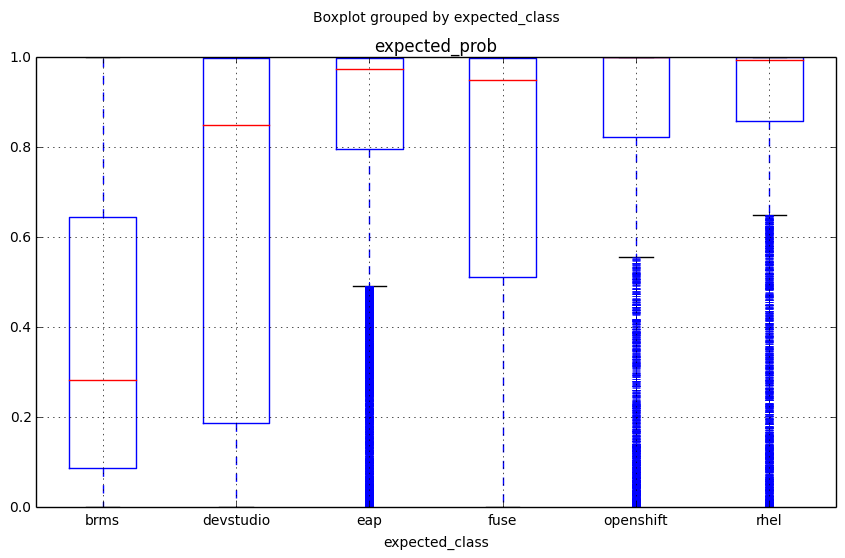

In [14]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,6))